In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="riddhikariddhika"
os.environ["KAGGLE_KEY"] = "d3a37094635008125f798e2a88ca6e8e"
!kaggle datasets download -d diayruldip/carinocroma

carinocroma.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data
data_dir = "/content/drive/MyDrive/cancer data"
class_names = os.listdir(data_dir)
class_names

['train', 'test', 'valid']

In [ ]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


In [ ]:
#creating functions to make dataframe
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # for train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # for validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # for test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df
#creating functions to generate images from dfs
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

#function to show images
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (10, 10))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()



Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


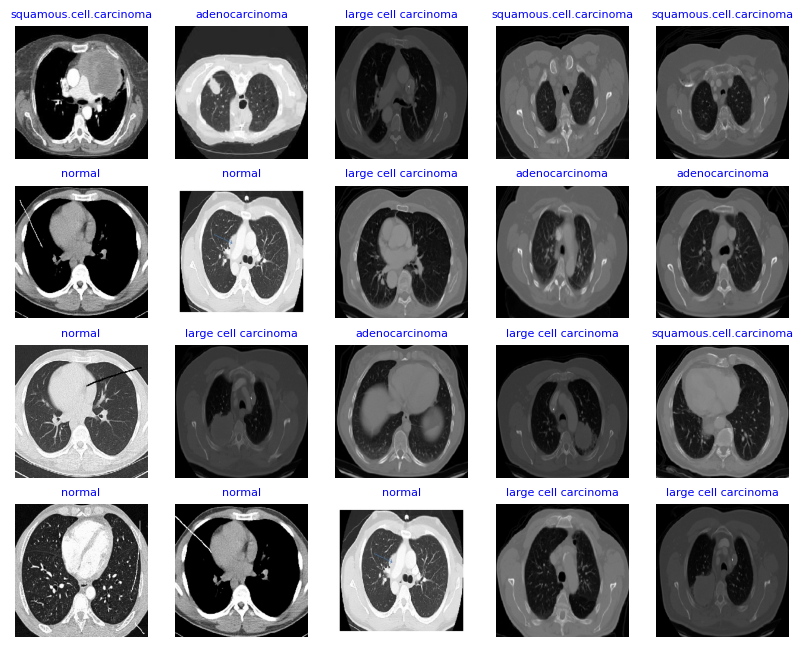

In [ ]:
train_dir = '/content/drive/MyDrive/cancer data/train'
test_dir = '/content/drive/MyDrive/cancer data/test'
valid_dir = '/content/drive/MyDrive/cancer data/valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

batch_size = 20
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [ ]:
#MODEL STRUCTURE
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# pre-trained cnn model=>efficientnetb3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()



43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non

In [ ]:
history=model.fit(train_gen, epochs=10, steps_per_epoch=len(train_gen), validation_data=valid_gen, validation_steps=len(valid_gen),callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)])

Epoch 1/10
31/31 [==============================] - 441s 13s/step - loss: 8.8428 - accuracy: 0.6117 - val_loss: 9.8520 - val_accuracy: 0.5139
Epoch 2/10
31/31 [==============================] - 366s 12s/step - loss: 7.4783 - accuracy: 0.8385 - val_loss: 8.1531 - val_accuracy: 0.5417
Epoch 3/10
31/31 [==============================] - 365s 12s/step - loss: 6.7623 - accuracy: 0.9021 - val_loss: 7.2466 - val_accuracy: 0.6250
Epoch 4/10
31/31 [==============================] - 364s 12s/step - loss: 6.2085 - accuracy: 0.9462 - val_loss: 6.5994 - val_accuracy: 0.6667
Epoch 5/10
31/31 [==============================] - 365s 12s/step - loss: 5.7214 - accuracy: 0.9674 - val_loss: 6.0040 - val_accuracy: 0.7639
Epoch 6/10
31/31 [==============================] - 361s 12s/step - loss: 5.3214 - accuracy: 0.9690 - val_loss: 5.6336 - val_accuracy: 0.7639
Epoch 7/10
31/31 [==============================] - 361s 12s/step - loss: 4.9871 - accuracy: 0.9837 - val_loss: 5.3395 - val_accuracy: 0.7639
Epoch 

In [ ]:
#results of model
#predictions by model
x_pred=model.predict(train_gen)
print(x_pred)

31/31 [==============================] - 80s 2s/step
[[0.25833365 0.04893369 0.04821147 0.6445212 ]
 [0.101949   0.0324147  0.0888337  0.77680254]
 [0.9888266  0.00212417 0.00525988 0.00378929]
 ...
 [0.2677782  0.04021192 0.0795034  0.6125065 ]
 [0.31485888 0.33051    0.32646912 0.02816198]
 [0.00781611 0.9669456  0.0154433  0.00979496]]


In [ ]:
#predicted output
y_pred=np.argmax(x_pred,axis=1)
print(y_pred)


[3 3 0 0 3 0 3 3 1 0 2 0 2 0 1 2 3 3 1 3 0 2 3 2 1 1 3 0 2 0 3 3 2 2 2 1 3
 1 3 1 2 0 2 3 0 1 2 3 2 2 1 2 2 1 0 3 3 2 2 3 1 1 0 0 2 2 1 3 3 2 0 0 0 3
 2 0 3 3 2 3 0 3 1 0 0 0 3 3 1 3 1 2 0 1 3 3 0 2 1 0 3 0 0 1 1 0 1 0 2 1 3
 0 1 0 1 1 0 0 3 2 1 2 1 0 3 3 2 1 2 0 0 0 2 2 3 0 1 3 0 0 0 0 0 0 3 1 1 3
 2 0 0 3 2 2 0 0 2 0 0 0 0 0 2 2 1 0 1 3 0 1 1 2 2 1 0 3 0 2 1 2 0 1 1 3 2
 0 1 0 3 0 1 0 0 2 1 3 0 0 3 2 0 0 2 3 1 2 0 3 0 3 2 3 0 2 0 0 2 1 3 2 2 2
 3 0 1 3 0 0 0 1 1 0 2 3 3 1 2 0 3 1 2 0 2 0 3 0 0 3 0 0 0 1 1 3 2 0 0 2 0
 2 0 1 0 0 0 0 3 0 0 3 0 0 3 1 2 2 2 3 0 2 2 3 3 0 1 2 1 2 0 0 3 3 3 0 0 2
 1 1 0 2 0 3 1 0 2 2 2 2 2 0 1 0 3 0 3 0 3 0 0 3 0 3 2 3 0 0 2 0 1 0 1 2 1
 0 2 3 1 2 3 1 3 3 2 3 2 3 0 1 3 2 0 3 3 3 2 3 3 2 0 3 2 2 2 3 2 2 3 2 2 2
 3 2 3 3 1 0 1 3 1 2 0 2 2 0 3 3 0 0 0 0 3 1 2 1 0 2 1 1 0 2 0 2 3 2 0 3 1
 3 2 1 3 3 0 0 3 0 0 2 0 0 3 1 2 3 0 2 2 0 3 1 2 2 0 3 0 0 2 3 0 1 0 1 2 3
 0 1 0 0 0 0 1 1 0 0 3 0 1 1 0 3 1 1 0 3 1 0 2 3 2 3 3 1 1 3 3 2 0 3 0 3 0
 0 0 0 3 0 1 3 0 0 0 3 2 

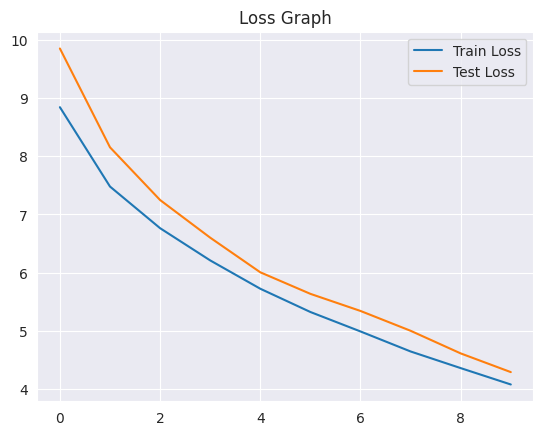

In [ ]:
#graph of training data loss and testing data loss
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

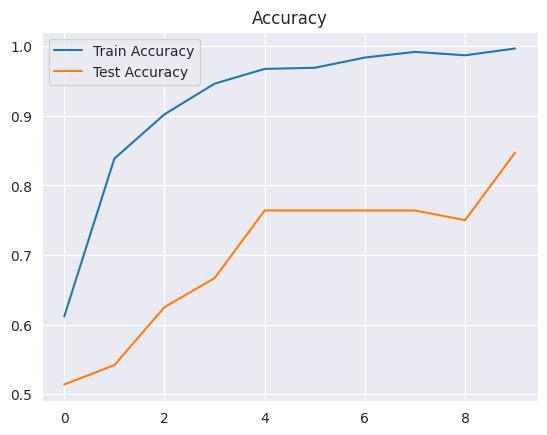

In [ ]:
#graph of training data accuracy and testing data accuracy
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Test Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluation of model
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/5 [=======================>......] - ETA: 2s - loss: 4.2881 - accuracy: 0.8472

5/5 [==============================] - 118s 27s/step - loss: 4.5561 - accuracy: 0.7429
Train Loss:  4.006389617919922
Train Accuracy:  0.9599999785423279
--------------------
Validation Loss:  4.288078308105469
Validation Accuracy:  0.8472222089767456
--------------------
Test Loss:  4.556105613708496
Test Accuracy:  0.7428571581840515
